In [1]:
import sys
sys.path.append('..')

In [2]:
from datetime import datetime
from pathlib import Path
from itertools import product, combinations
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import trange, tqdm

from cashback_calculator.db import Card, N_MCCS, ALL_MCCS, MCC2ID, ID2MCC, \
    MCC_CATEGORIES, CARD_IDS
from cashback_calculator.two_card_strategy_optimisation import optimize_cashback, \
    optimize_cashback_for_cards

from myutils.json import save_json, load_json

%config InlineBackend.figure_formats = ['svg']
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('deep'))
plt.rcParams['grid.linestyle'] = 'dotted'

In [3]:
rcparams = {
    'text.usetex' : True,
    'font.family': [
        'serif'
    ],
    'font.serif': [
        'Computer Modern Roman',
        'Times',
        'Palatino',
        'New Century Schoolbook',
        'Bookman',
    ],
}

plt.rcParams.update(rcparams)

In [4]:
dblue = '#27488b'
dred = '#d91f43'

In [5]:
MCC_CATEGORIES = {
    category: mccs[:1]
    for category, mccs in MCC_CATEGORIES.items()
}

MCC2CATEGORY = {
    mcc: category
    for category, mccs in MCC_CATEGORIES.items()
    for mcc in mccs
}

MCC2CATEGORY

{'5811': 'restaurants',
 '5814': 'fastfood',
 '5541': 'fuel',
 '4121': 'taxi',
 '5411': 'groceries',
 '5912': 'pharmacies',
 '7832': 'cinema',
 '3000': 'airlines',
 '1711': 'other'}

In [6]:
cards = [Card(card_id) for card_id in CARD_IDS]

len(cards)

14

In [7]:
def get_vector(amount_spent_by_category) -> np.ndarray:
    vector = np.zeros(N_MCCS)
    
    for key, value in amount_spent_by_category.items():
        if value > 0:
            value -= 0.01
            mccs = MCC_CATEGORIES[key]
            n_mccs = len(mccs)
            mask = list(map(MCC2ID.get, mccs))
            vector[mask] = value / n_mccs
            
    return vector

In [8]:
amount_spent_by_category = {'restaurants': 15015, 'groceries': 17258}

vector = get_vector(amount_spent_by_category) * 6
nonzero_ids = np.where(vector > 0)[0]

nonzero_ids, vector[vector > 0], vector.sum()

(array([371, 411]), array([103547.94,  90089.94]), 193637.88)

In [9]:
v1, v2 = vector[vector > 0]
v1, v2

(103547.94, 90089.94)

In [10]:
for card in cards:
    print(card.card_id, card.benchmarks)

tinkoff_black [ 0. inf]
tinkoff_drive [ 0. inf]
raiffeisen_cashback [ 0. inf]
raiffeisen_gold [    0. 30000.    inf]
bspb_classic [ 0. inf]
bspb_visa-cashback [ 0. inf]
bspb_pensionary [ 0. inf]
bspb_yarkaya [    0. 50000.    inf]
bspb_ekp [    0. 15000. 50000.    inf]
bspb_travel [ 0. inf]
alfabank_cashback [     0.  10000.  70000. 100000.     inf]
alfabank_alfa-carta [     0.  10000. 100000.     inf]
alfabank_next [   0. 5000.   inf]
sberbank_karta-s-bolshimi-bonusami [ 0. inf]


In [11]:
c1 = Card('alfabank_cashback')
c2 = Card('bspb_yarkaya')

c1.benchmarks, c2.benchmarks

(array([     0.,  10000.,  70000., 100000.,     inf]),
 array([    0., 50000.,    inf]))

In [12]:
def foo(x: np.ndarray, c1: Card, c2: Card, vector: np.ndarray) -> float:
    nonzero_ids = np.where(vector > 0)[0]
    assert nonzero_ids.size == x.size
    
    vector_ = np.zeros(vector.size)
    vector_[nonzero_ids] = x
    
    return c1.calculate_profit(vector_) + c2.calculate_profit(vector - vector_)

In [13]:
ox = np.linspace(0, v1, 600)
oy = np.linspace(0, v2, 600)

oz = np.zeros((ox.size, oy.size))

for i in trange(ox.size):
    for j in range(oy.size):
        x = ox[i]
        y = oy[j]
        z = foo(np.array([x, y]), c1, c2, vector)
        oz[i, j] = z
        
ox, oy = np.meshgrid(ox, oy)

ox /= 5
oy /= 5
oz /= 5

  0%|          | 0/600 [00:00<?, ?it/s]

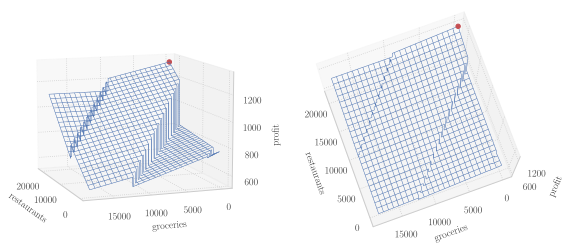

In [15]:
fig = plt.figure(figsize=(8, 3.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')


for ax in [ax1, ax2]:
    ax.plot_wireframe(ox, oy, oz, linewidth=0.5, rstride=25, cstride=25, zorder=9, color='C0')

    ax.set_ylabel('groceries')
    ax.set_zlabel('profit')
    
    i, j = np.where(oz == oz.max())
    
    ax.scatter(ox[i, j][:1], oy[i, j][:1], oz[i, j][:1], color='C3', zorder=15)
    
    ax.xaxis.set_tick_params(color='None')
    ax.yaxis.set_tick_params(color='None')
    ax.zaxis.set_tick_params(color='None')
    
    ax.set_yticks([0, 5000, 10000, 15000])
    
ax1.view_init(10, 160)
ax2.view_init(78, 160)

ax1.set_xticks([0, 10000, 20000])
ax2.set_zticks([600, 1200])

ax1.set_xlabel('restaurants')
ax2.set_xlabel('restaurants', labelpad=10)

#fig.suptitle('Оптимизация разбиения трат по двум категориям', fontsize=15)
fig.subplots_adjust(top=0.96, bottom=0.02, left=0.02, right=0.93, wspace=0.2) 

plt.savefig('../data/figures/2d_functional.pdf', transparent=False, bbox_inches='tight')